# Evictions in LA 2023

## Introduction
This project undertakes an in-depth spatial analysis of eviction trends in Los Angeles, leveraging advanced techniques and multiple datasets. By integrating the 2023 eviction dataset, geocoded information, Social Vulnerability Index (SVI) data, census tract data, and rent datasets, the aim is to uncover spatial clustering patterns within eviction occurrences. The analysis goes beyond global assessments, we investigate local spatial autocorrelation to identify statistically significant clusters and provide a deeper understanding of the socio-economic factors contributing to these patterns. The final output will be a comprehensive map that visually represents the locations of significant eviction clusters, accompanied by descriptive statistics to enrich the interpretation. This advanced spatial analysis promises to offer valuable insights into the geographical dynamics of evictions in Los Angeles.

## Import Libraries

In [66]:
import pandas as pd
import geopandas as gpd 
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from libpysal.weights import KNN
import esda
from esda.moran import Moran
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal 
import seaborn as sns
import contextily
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import MinMaxScaler
from statsmodels.formula.api import glm
from patsy import dmatrices
from pygris import tracts
import bambi as bmb
import arviz as az


## Loading the Data 
In this section, we are loading various datasets essential for our eviction analysis project. The datasets include information on eviction filings in 2023, geocoded eviction data, the Social Vulnerability Index (SVI) for Los Angeles, and rental-related data. These datasets will serve as the foundation for conducting advanced spatial analyses and exploring patterns related to evictions in Los Angeles.

In [67]:

evictions = pd.read_csv('data/2023_eviction_filings_final.csv')
evictions_geocoded = pd.read_csv('data/evictions_geocoded.csv')
svi_la = pd.read_csv('data/SVI_la.csv',dtype={'FIPS':str})
rent_df = pd.read_csv('data/ACSST5Y2020.S2502-Data.csv',dtype={'FIPS':str})



The provided code is creating a GeoDataFrame (gdf_ct) that represents census tracts in Los Angeles County, California

In [68]:
gdf_ct = gpd.read_file('data/LA_City_2020_Census_Tracts_.geojson')

## Data Cleaning
We perform address standardization and geospatial transformation data cleaning tasks. To perform the data cleaning task of address standardization the 'Address' column in the 'evictions' DataFrame is converted to a string data type. To perform the geospatial data handling task a new 'Address' column is created in the 'evictions geocoded' GeoDataFrame, aligning with the 'input string' column, and ensuring it is of string data type. Geospatial information is introduced to the 'evictions geocoded' GeoDataFrame by creating a geometry column using latitude and longitude columns. The GeoDataFrame is merged with the 'evictions' DataFrame based on index alignment. The coordinate reference system (CRS) is set to EPSG 3857 for spatial consistency. We perform these steps to ensure uniformity in addressing and enabling geospatial analysis and visualization.

In [69]:
# Convert evictions 'Address' to string
evictions['Address'] = evictions['Address'].astype(str)

# Create new column in evictions_geocode with matching name 'Address' and make sure it's a string
evictions_geocoded['Address'] = evictions_geocoded['input_string'].astype(str)
evictions_geocoded = gpd.GeoDataFrame(evictions_geocoded,geometry=gpd.points_from_xy(evictions_geocoded['longitude'],evictions_geocoded['latitude']),crs='4326')
evics = evictions_geocoded.merge(evictions,left_index=True,right_index=True)
evics = evics.to_crs(epsg='3857')




We perform data selection and column renaming tasks. The 'rent_df' DataFrame is updated to retain only the 'FIPS' and 'S2502_C05_001E' columns. The 'S2502_C05_001E' column is renamed to 'renter_occupied' in the 'rent_df' DataFrame. These actions streamline the dataset by focusing on specific columns and provide clear, descriptive names for relevant variables.

In [70]:
rent_df = rent_df[['FIPS','S2502_C05_001E']]
rent_df = rent_df.rename(columns={'S2502_C05_001E':'renter_occupied'})

In [71]:
# Showing first few rows of the GeoDataFrame 'gdf_ct' using the 'head()' function
gdf_ct.head()

,OBJECTID,CT20,LABEL,Shape__Area,Shape__Length,geometry
0,1,101110,1011.10,1.676519e+06,5565.411341,"POLYGON ((-118.29793 34.26323, -118.29697 34.2..."
1,2,101122,1011.22,3.881001e+06,11695.304277,"POLYGON ((-118.27743 34.25991, -118.27747 34.2..."
2,3,101220,1012.20,1.025452e+06,4688.607147,"POLYGON ((-118.27818 34.25577, -118.27824 34.2..."
3,4,101221,1012.21,5.197057e+05,3378.824327,"POLYGON ((-118.28735 34.25591, -118.28735 34.2..."
4,5,101222,1012.22,4.350619e+05,3685.233312,"POLYGON ((-118.28594 34.25590, -118.28594 34.2..."


In [72]:
#Filter the DataFrame 'svi_la' to include only rows where the 'COUNTY' column is equal to 'Los Angeles'
svi_la = svi_la[svi_la['COUNTY'] == 'Los Angeles']

## Geospatial Data Transformation and Preparation 
We carried four steps in the transformation and preparation of geospatial data which include coordinate system transformation, column selection,column renaming, and visualization. The GeoDataFrame 'gdf_ct' is converted to the EPSG 3857 coordinate reference system (CRS). With Column selection the DataFrame is then trimmed to retain only the 'GEOID' and 'geometry' columns. Column renaming involved columns being renamed to 'FIPS' and 'geometry' for clarity. The last step visualization involves plotting the GeoDataFrame to visualize the geospatial data after the transformations  

In [73]:
gdf_ct = gdf_ct.to_crs(epsg='3857')

# trim the data to the bare minimum columns
gdf_ct = gdf_ct[['CT20','geometry']]

gdf_ct['CT20'] = '06037' + gdf_ct['CT20']



# rename the columns
gdf_ct.columns = ['FIPS','geometry']




We perform data filtering by checking for the presence of FIPS codes from the 'gdf_ct' GeoDataFrame in the 'FIPS' column of the 'svi_la' DataFrame. The resulting boolean mask is used to filter the data, selecting rows where the FIPS codes match between the two datasets

In [74]:
svi_la['FIPS'].isin(gdf_ct['FIPS'])

1378     True
1379     True
1380     True
1381     True
1382     True
        ...  
3868    False
3869    False
3870     True
3871     True
3872     True
Name: FIPS, Length: 2495, dtype: bool

### Process and merge dataframes
We conduct various data merging and cleaning operations. We begin by merging tract geographical data with the Social Vulnerability Index (SVI) data. Subsequently, specific columns are selected and renamed for clarity. The dataset is then joined with the eviction data through a spatial join, creating a new 'evictions_count' column to tally evictions per tract. We further merge the dataframe with a dataset containing the total number of rental units per census tract. Tracts without rental units are removed, and the final dataset is scaled by 1000 for normalization. The resulting GeoDataFrame, 'gdf_ct,' is now ready for further analysis.

<Axes: >

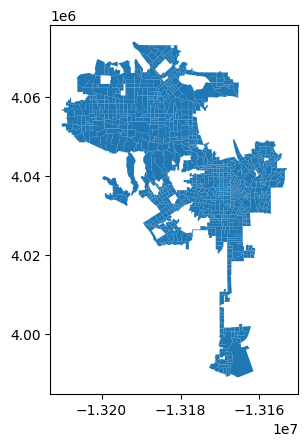

In [75]:
# Merge tract geo data with social vulnerability index data
gdf_ct = gdf_ct.merge(svi_la,on='FIPS')

# Select and rename columns
gdf_ct = gdf_ct.loc[:, ['FIPS','E_TOTPOP', 'E_HU', 'E_HH', 'EP_POV150', 'EP_UNEMP','EP_NOHSDP', 'EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_MINRTY', 'EP_LIMENG', 'EP_MUNIT', 'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ', 'geometry']]
gdf_ct = gdf_ct.rename(
    columns={'E_TOTPOP':'total_pop','E_HU':'housing_units','E_HH':'households','EP_POV150':'pov_below150','EP_UNEMP':'unemployed','EP_PCI':'cost_burdened_low_income','EP_NOHSDP':'no_high_school','EP_AGE65':'persons_over65','EP_AGE17':'persons_under17','EP_DISABL':'disabled_pop','EP_SNGPNT':'single_parent','EP_MINRTY':'minority_pop','EP_LIMENG':'limited_eng','EP_MUNIT':'10_units_plus','EP_MOBILE':'mobile_homes','EP_CROWD':'crowded_units','EP_NOVEH':'no_vehicle','EP_GROUPQ':'persons_group_quarters'
})

# Join cleaned up dataset with evictions using spatial join. Also create a new column of 'evictions_count' to count per tract
join = gdf_ct.sjoin(evics)
evics_ct = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='evictions_count')
gdf_ct=gdf_ct.merge(evics_ct,on='FIPS')

# Merge our dataframe with dataset containing total number of rental units per census tract
gdf_ct = gdf_ct.merge(rent_df,on='FIPS')

# Remove tracts without rental units and scale by 1000 
gdf_ct = gdf_ct[gdf_ct['renter_occupied']>0]
gdf_ct['count_norm'] = gdf_ct['evictions_count'] / gdf_ct['renter_occupied'] * 100
gdf_ct.plot()

### Preliminary visualization of outcome variable

We outputs a list of column names present in the GeoDataFrame 'gdf_ct.' This provides a quick overview of the available columns for reference and analysis.

In [76]:
gdf_ct.columns.to_list()

['FIPS',
 'total_pop',
 'housing_units',
 'households',
 'pov_below150',
 'unemployed',
 'no_high_school',
 'persons_over65',
 'persons_under17',
 'disabled_pop',
 'single_parent',
 'minority_pop',
 'limited_eng',
 '10_units_plus',
 'mobile_homes',
 'crowded_units',
 'no_vehicle',
 'persons_group_quarters',
 'geometry',
 'evictions_count',
 'renter_occupied',
 'count_norm']

Non parametric testing because of difference in mean and median

## Data Exploration
In this stage, we venture into exploring and analyzing the datasets. The focus is on understanding the spatial distribution of evictions, social vulnerability, and rental units across Los Angeles. We aim to uncover patterns, relationships, and insights that will inform subsequent spatial analyses and policy recommendations

The task below using the function 'describe' calculates descriptive statistics for the 'count_norm' column in the GeoDataFrame 'gdf_ct', providing insights into the distribution of normalized eviction counts per rental unit in the census tracts.

These statistics provide an overview of the distribution of normalized eviction counts per rental unit in the census tracts. The mean (7.82) represents the average normalized count, while the standard deviation (14.22) indicates the degree of variability around the mean. The quartiles (Q1, Q3) help understand the distribution, and the minimum and maximum values show the range of normalized counts. The data suggests a positively skewed distribution with a potentially wide range of counts, with some tracts experiencing significantly higher normalized eviction counts compared to others.

In [77]:
gdf_ct['count_norm'].describe()

count    1085.000000
mean        8.053757
std        14.145679
min         0.132626
25%         2.103250
50%         3.817603
75%         8.106312
max       237.288136
Name: count_norm, dtype: float64

### Scale data using a min max scaler

The variable list 'census_vars' includes the following socioeconomic and demographic indicators. These variables encompass a range of factors relevant to the social and economic characteristics of census tracts, providing a comprehensive set of indicators for further analysis and exploration

In [78]:
#create variable list using census_vars
census_vars = [
 'pov_below150',
 'unemployed',
 'no_high_school',
 'minority_pop',
 '10_units_plus',
 'mobile_homes',
 'crowded_units',
 'renter_occupied',
 'count_norm'
]

The MinMaxScaler has been applied to normalize the values of the variables in the census_vars list. This scaling technique transforms the values of each variable to a range between 0 and 1, maintaining the relative proportions of the data while ensuring consistency in scale across different variables. This process allow for a fair comparison and accurate model training on the normalized data

In [79]:
#normalize the various values in census_vars using MinMaxScaler function 
scaler = MinMaxScaler()
gdf_ct[census_vars] = scaler.fit_transform(gdf_ct[census_vars])


The describe() method has been applied to the GeoDataFrame gdf_ct, generating a summary table that provides descriptive statistics for each numerical variable in the dataset. The key findings show that variables such as poverty levels, unemployment, education attainment, and age distribution exhibit diverse patterns. For instance, the average percentage of households with no high school diploma is relatively high, indicating potential educational disparities. Additionally, the presence of single-parent households and households with persons over 65 years varies across tracts, suggesting distinct demographic characteristics. These findings lay the foundation for understanding the socio-economic landscape and its potential impact on eviction patterns in Los Angeles.

In [80]:
#use describe function to gdf_ct dataframe
table = gdf_ct.describe()
table

,total_pop,housing_units,households,pov_below150,unemployed,no_high_school,persons_over65,persons_under17,disabled_pop,single_parent,minority_pop,limited_eng,10_units_plus,mobile_homes,crowded_units,no_vehicle,persons_group_quarters,evictions_count,renter_occupied,count_norm
count,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.00000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000
mean,3605.880184,1380.272811,1278.934562,0.286045,0.161081,0.303752,13.026544,19.66682,10.386083,6.318341,0.685735,14.248664,0.358871,0.022877,0.220357,12.276682,1.878618,69.830415,0.272063,0.033401
std,1148.114644,486.694981,436.039997,0.167752,0.094380,0.229385,6.383149,7.85334,4.650755,5.746461,0.276586,11.031937,0.298700,0.092768,0.184311,11.309043,7.594934,133.422050,0.149008,0.059647
min,65.000000,17.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2796.000000,1039.000000,970.000000,0.146934,0.103044,0.095368,8.600000,14.70000,7.600000,2.400000,0.452229,4.500000,0.095000,0.000000,0.062883,4.500000,0.000000,11.000000,0.163834,0.008309
50%,3478.000000,1335.000000,1240.000000,0.260042,0.147541,0.269755,12.100000,19.70000,9.800000,5.100000,0.761146,12.700000,0.303000,0.000000,0.182515,9.300000,0.200000,28.000000,0.260367,0.015538
75%,4369.000000,1668.000000,1530.000000,0.402748,0.201405,0.493188,16.500000,24.90000,12.400000,8.700000,0.942675,21.900000,0.582000,0.000000,0.346626,16.500000,1.100000,66.000000,0.369477,0.033622
max,9559.000000,4733.000000,4329.000000,1.000000,1.000000,1.000000,53.200000,50.80000,60.800000,81.800000,1.000000,63.100000,1.000000,1.000000,1.000000,86.400000,96.400000,1554.000000,1.000000,1.000000


The correlation matrix and heatmap illustrate the relationships between various socio-economic indicators in the dataset. The results show some positive correlations. There is a positive correlation between the percentage of households with incomes below 150% of the poverty level (pov_below150) and the percentage of the population that is unemployed (unemployed). A positive correlation is observed between the percentage of housing units with more than 10 units (10_units_plus) and the percentage of crowded housing units (crowded_units). There is strong relationship between population with incomes below 150 to be unemployed with no high school from minority population and living in crowded unit.  The negative correlations- A negative correlation exists between the percentage of the population over 65 years old (persons_over65) and the percentage of single-parent households (single_parent). There is a negative correlation between the percentage of households with no high school diploma (no_high_school) and the percentage of the population with a disability (disabled_pop).

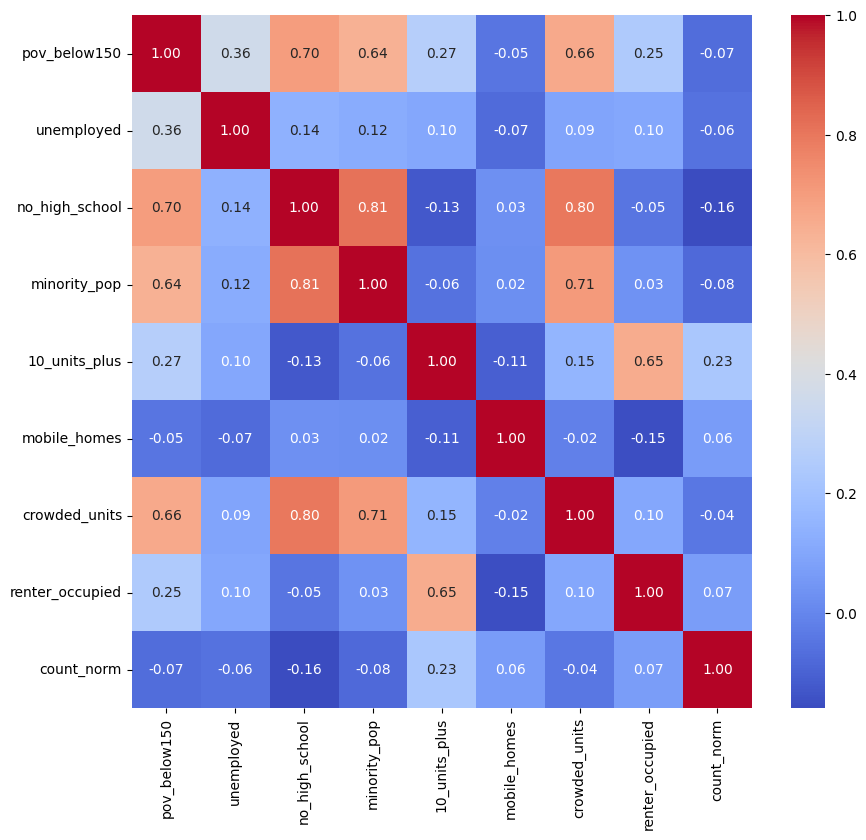

In [81]:
#Correlation matrix to analyze key variables
corr = gdf_ct[census_vars].corr()
plt.figure(figsize=(10,9))
sns.heatmap(corr,annot=True,cmap='coolwarm',fmt='.2f')
plt.show()

### Calculate variance inflation factor for each variable considering high collinearity based on data exploration

The VIF results indicate that the variables in the dataset generally have low to moderate multicollinearity.
The highest VIF value represents the potential variance inflation for the variable pov_below150, suggesting moderate correlation with other variables. The constant has a VIF of 14.19, suggesting low correlation and 'no_high_school' exhibits the highest VIF (5.80), indicating some correlation but generally acceptable. Overall, VIF values below typical thresholds, suggesting variables are suitable for regression modeling.

In [82]:
# calculate the Variance Inflation Factor (VIF) for each variable in the dataset
C = add_constant(gdf_ct[census_vars])

vif = pd.Series([variance_inflation_factor(C.values,i) for i in range(C.shape[1])],index=C.columns)
vif

const              14.001509
pov_below150        3.119917
unemployed          1.220426
no_high_school      5.806402
minority_pop        3.158217
10_units_plus       2.392278
mobile_homes        1.036846
crowded_units       3.504429
renter_occupied     1.819266
count_norm          1.105300
dtype: float64

The histogram plots illustrate the distribution of key variables in the GeoDataFrame gdf_ct. We see a right and left skewness of distribution and outliers in some variables. This visualization aids in understanding the spread and concentration of values within each variable, providing insights into the dataset's characteristics.

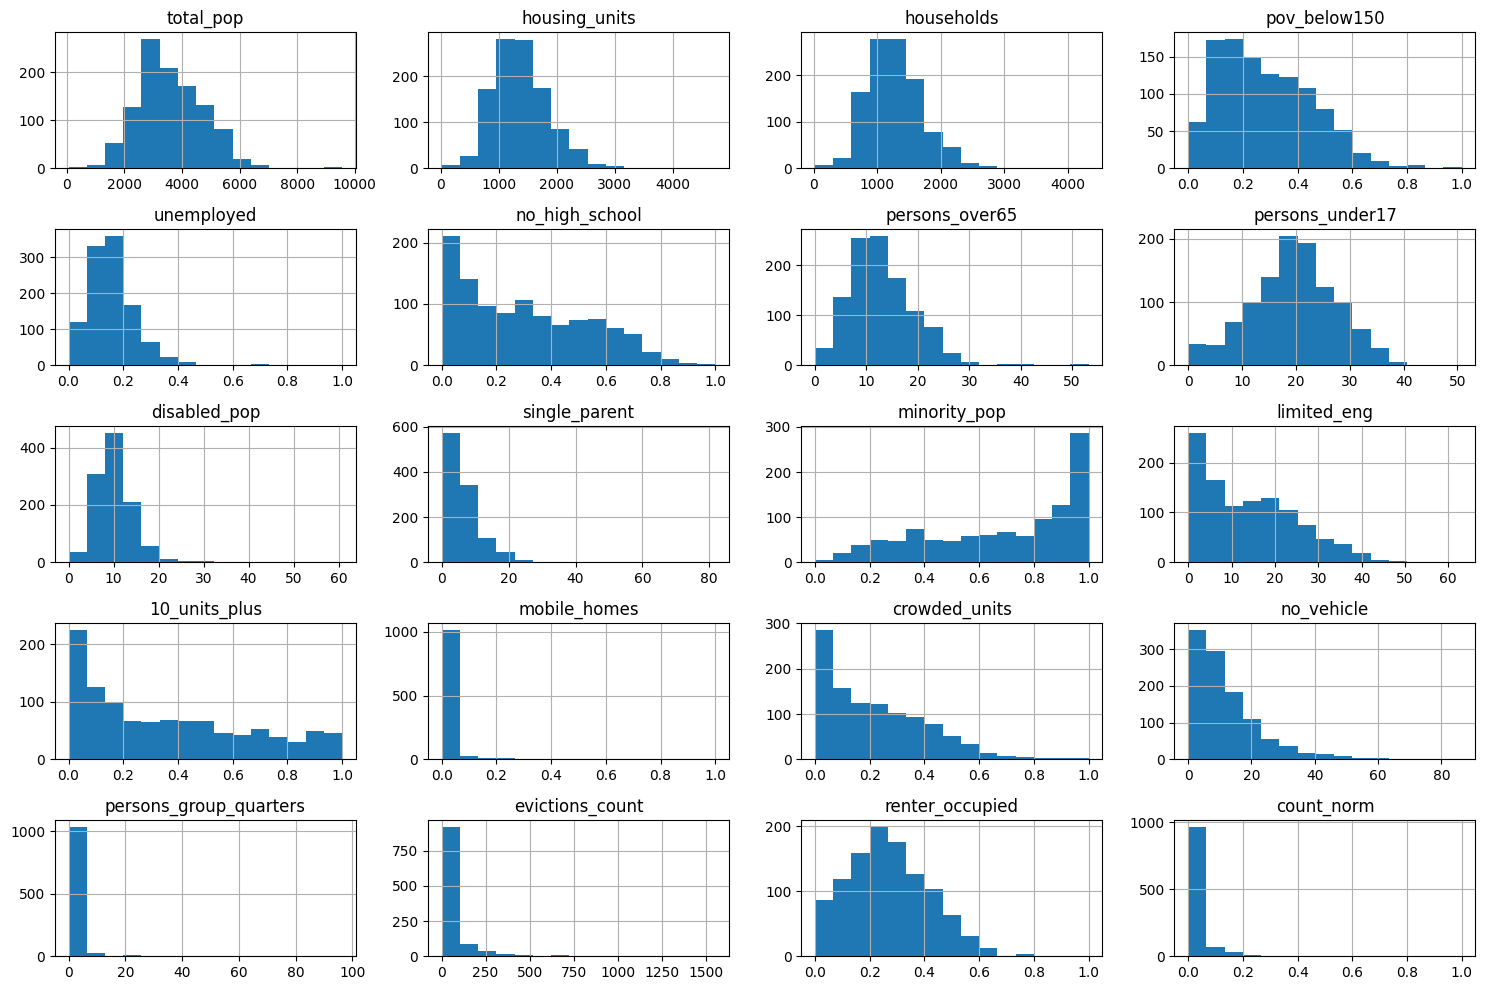

In [83]:
#Plot histogram of key variables
gdf_ct.hist(bins=15,figsize=(15,10))
plt.tight_layout()
plt.show()

The boxplots present the distribution of various census variables in the GeoDataFrame gdf_ct. Each subplot corresponds to a specific variable, displaying the median, quartiles, and potential outliers. 

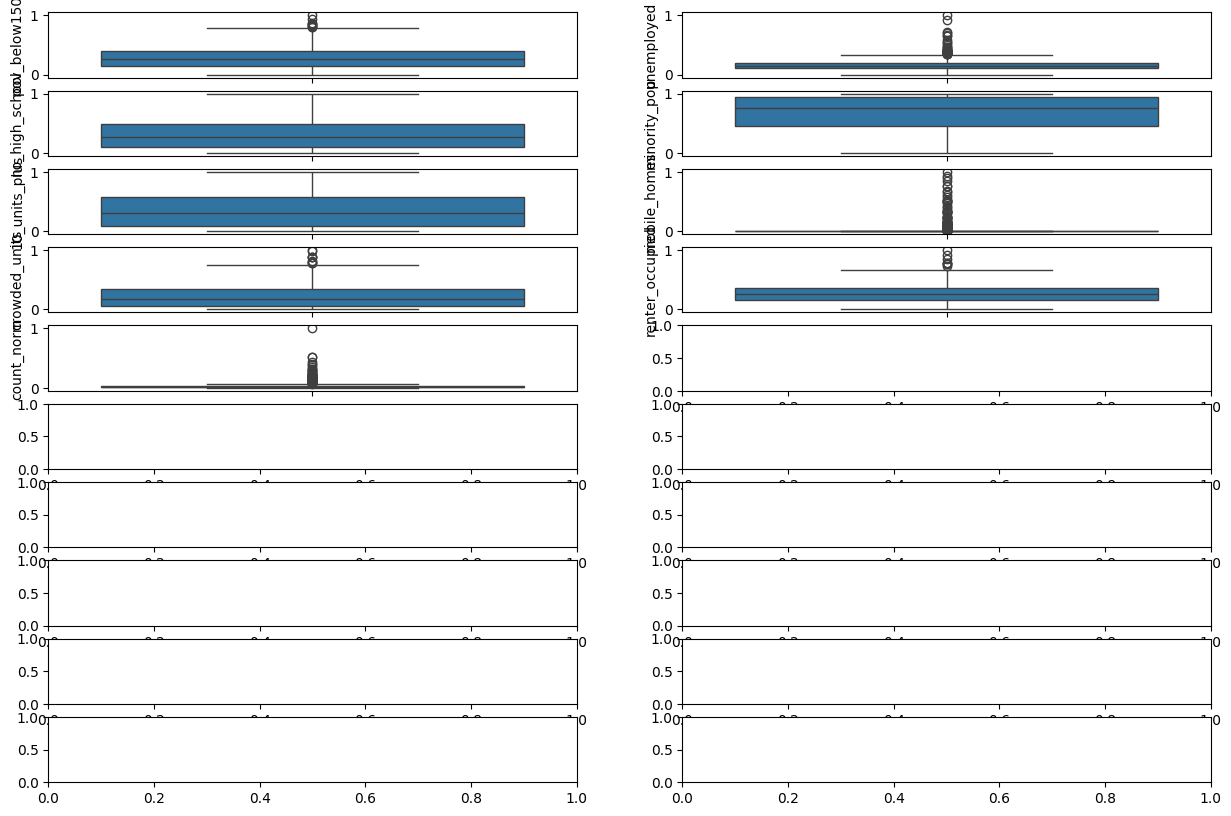

In [84]:
#Plot subplot 
fig, ax = plt.subplots(10,2,figsize=(15,10))
ax = ax.flatten()

for i, var in enumerate(gdf_ct[census_vars]):
    sns.boxplot(y=var,data=gdf_ct,ax=ax[i])
   
plt.show()

The pairplot below displays scatter plots for pairwise relationships between the selected census variables in the GeoDataFrame gdf_ct. Each point in the scatter plots represents a census tract, and the diagonal histograms illustrate the univariate distribution of each variable.
The scatter plots with regression lines provide insights into potential correlations between variables. For instance, the scatter plot between 'pov_below150' and 'unemployed' shows a negative trend, suggesting that higher levels of unemployment may be associated with a higher percentage of individuals living below 150% of the poverty line. Also, pov_below 150  with croded units, no high school and crowded units, and minority population and crowded units show positive linear relationships.

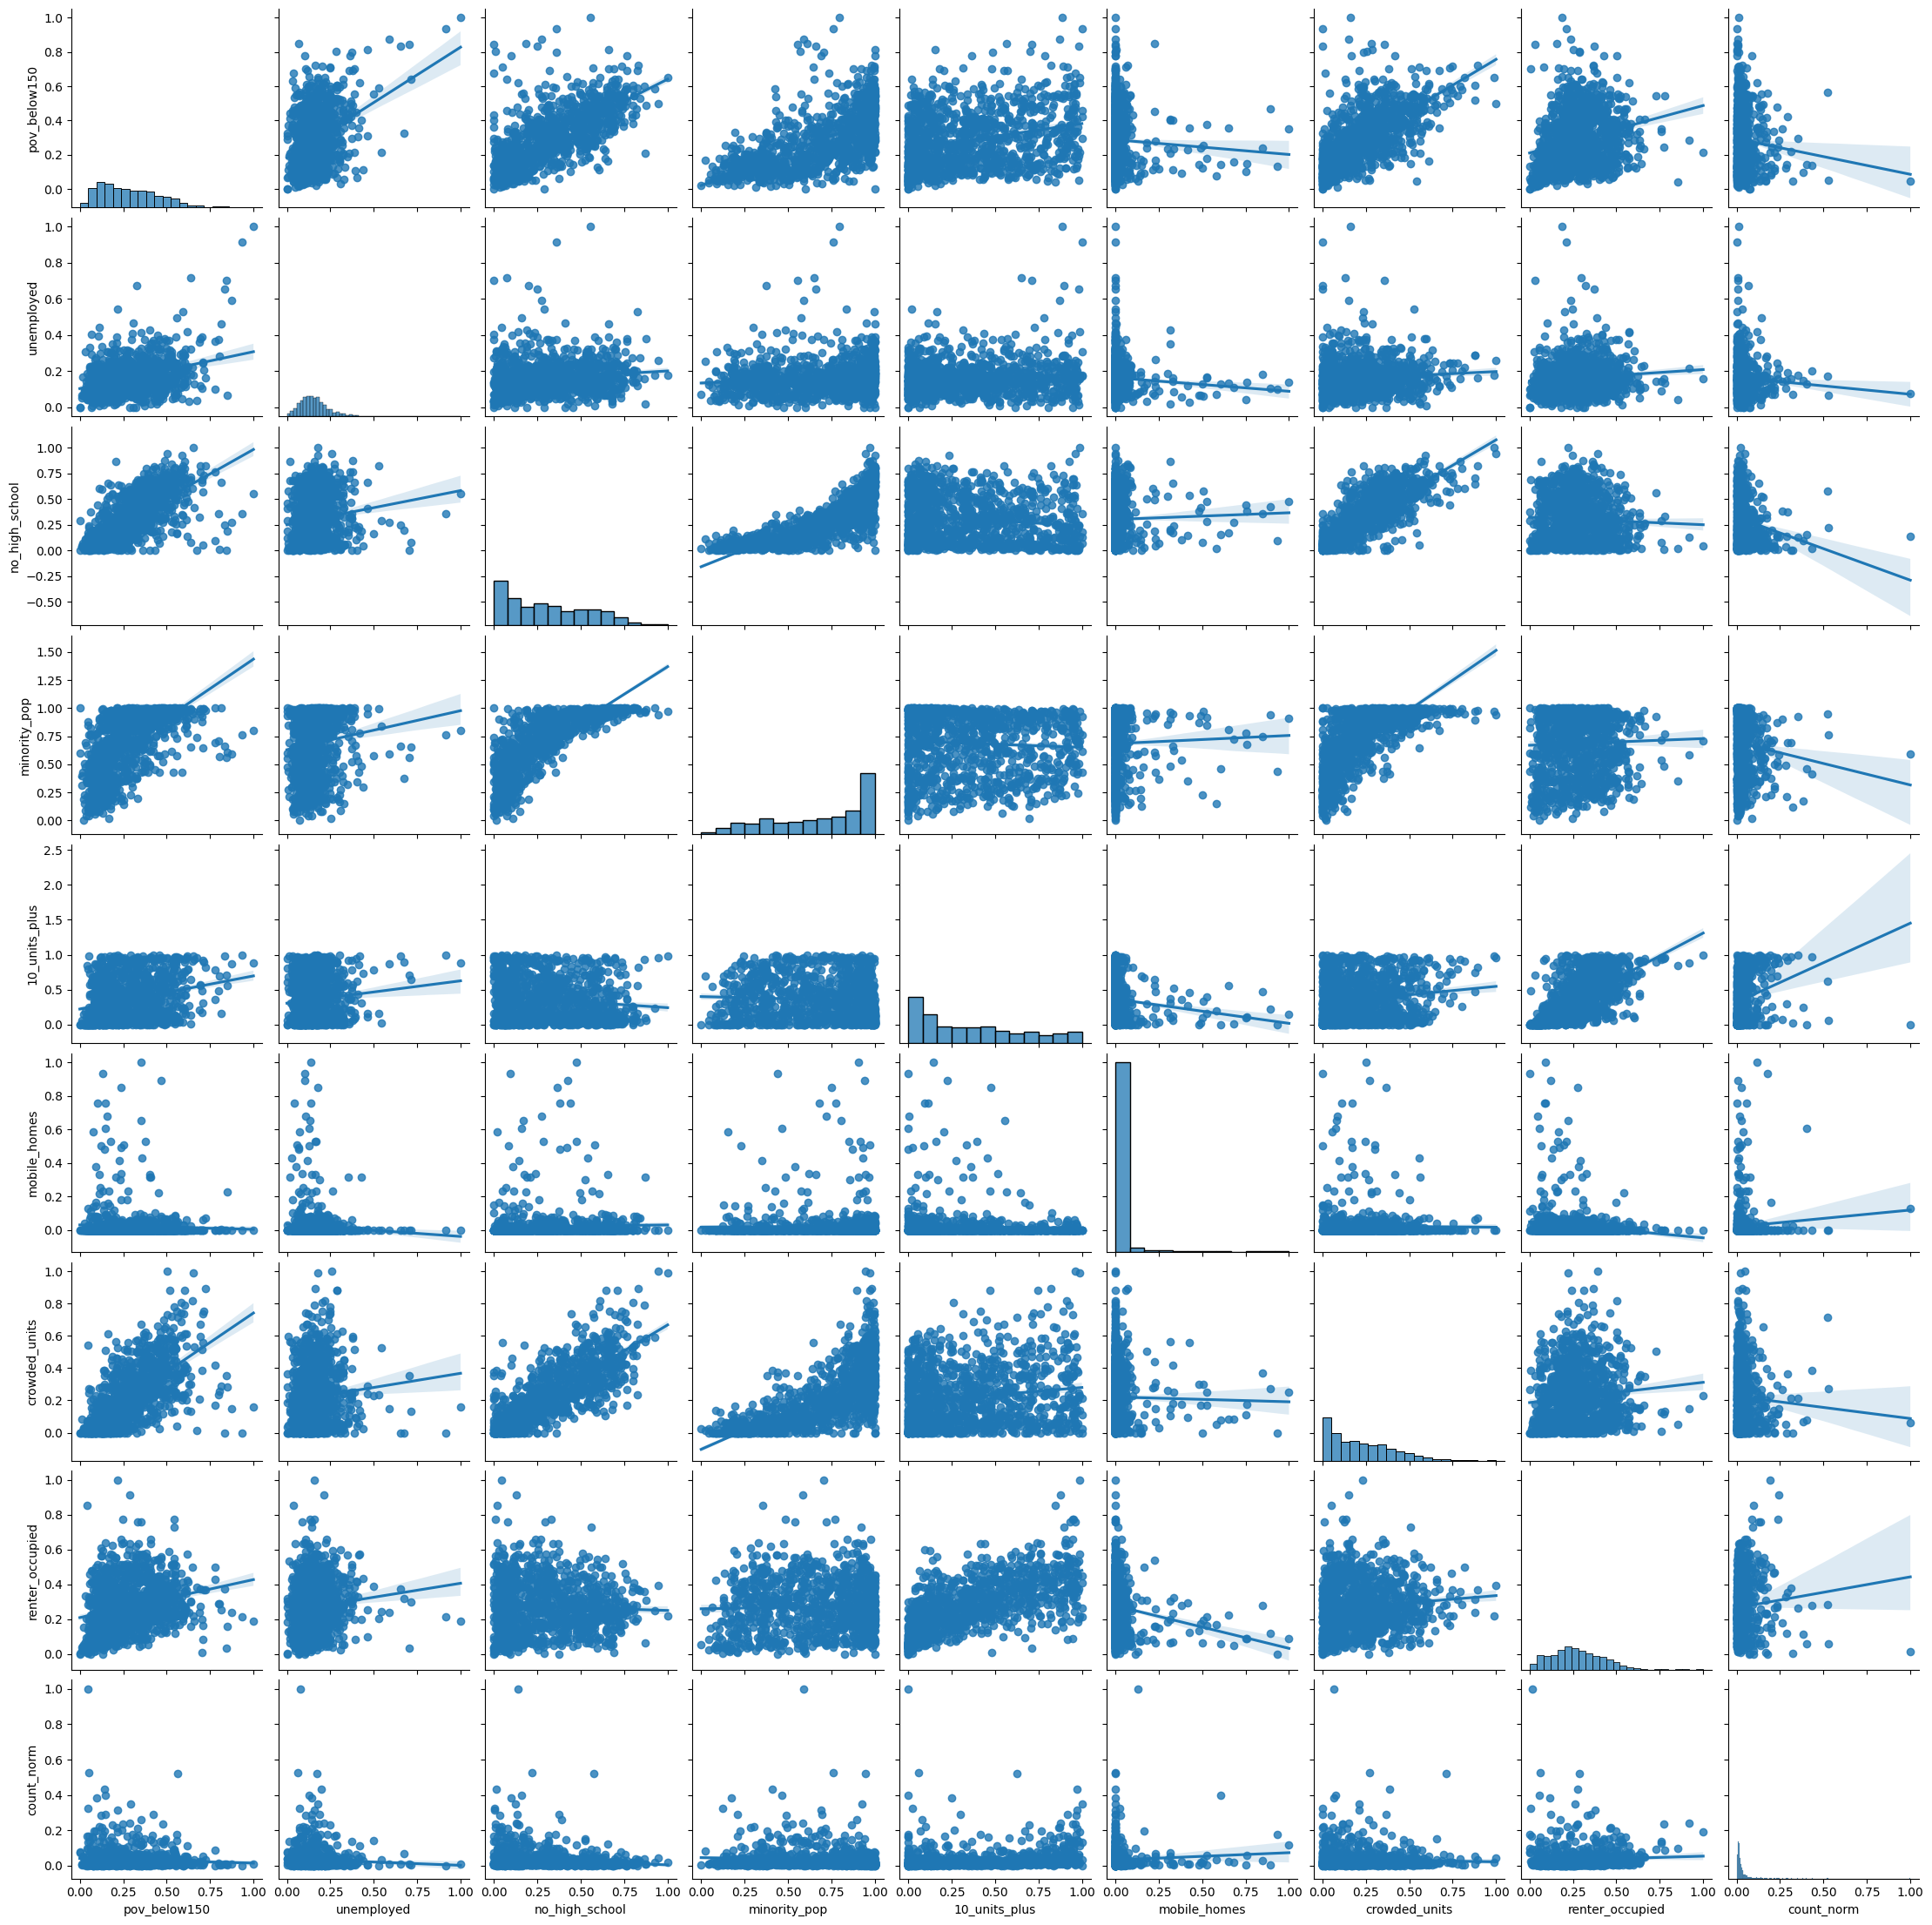

In [85]:
#Plot pairplot graphs
sns.pairplot(gdf_ct[census_vars],kind='reg')
plt.show()

The configuration below represents a visualization setup for geographical data related to evictions. The map is centered around the latitude 33.837184166330836 and longitude -118.46478962372794, focusing on the Los Angeles county area. Time range filter is based on the 'Notice Date', grid layer used to represent points on the map with each grid cell aggregating eviction data. The color of each cell indicates the count of evictions, following a diverging color scale (ColorBrewer RdYlGn-6). Tooltip functionality is enabled, displaying information about the "Notice Date" when hovering over eviction points.The map style is set to "dark" and animation features are configured.

In [86]:
config = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [
        {
          "dataId": [
            "evictions"
          ],
          "id": "sreoedtdg",
          "name": [
            "Notice Date"
          ],
          "type": "timeRange",
          "value": [
            1598918400000,
            1601078400000
          ],
          "enlarged": True,
          "plotType": "histogram",
          "yAxis": None
        }
      ],
      "layers": [
        {
          "id": "y8t676q",
          "type": "grid",
          "config": {
            "dataId": "evictions",
            "label": "Point",
            "color": [
              34,
              63,
              154
            ],
            "columns": {
              "lat": "latitude",
              "lng": "longitude"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.8,
              "worldUnitSize": 0.5,
              "colorRange": {
                "name": "ColorBrewer RdYlGn-6",
                "type": "diverging",
                "category": "ColorBrewer",
                "colors": [
                  "#1a9850",
                  "#91cf60",
                  "#d9ef8b",
                  "#fee08b",
                  "#fc8d59",
                  "#d73027"
                ],
                "reversed": True
              },
              "coverage": 1,
              "sizeRange": [
                0,
                500
              ],
              "percentile": [
                0,
                100
              ],
              "elevationPercentile": [
                0,
                100
              ],
              "elevationScale": 20.9,
              "colorAggregation": "count",
              "sizeAggregation": "count",
              "enable3d": True
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": None,
            "colorScale": "quantize",
            "sizeField": None,
            "sizeScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "evictions": [
              {
                "name": "Notice Date",
                "format": None
              },
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 24,
      "dragRotate": True,
      "latitude": 33.837184166330836,
      "longitude": -118.46478962372794,
      "pitch": 50,
      "zoom": 9,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "dark",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}

The code below utilizes the Kepler.gl library to create an interactive and customizable map visualization of eviction data. We import the KeplerGl module, which is a powerful geospatial visualization tool for creating dynamic maps. An instance of KeplerGl is created with a specified height, the `config` parameter is used to apply custom configuration settings to the map, the `map` instance is displayed, presenting an interactive map interface for exploring and analyzing eviction data.

In [87]:
from keplergl import KeplerGl
map = KeplerGl(height=600, width=800, data={'evictions':evics},config=config)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/Users/jackfukushima/anaconda3/lib/python3.11/site-packages/jupyter_client/session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['evictions'], 'id': 'sreoedt…

### Summary of exploration
The data is not normally distributed across multiple variables and several variables have high degrees of multicollinearity. The low numbers of mobile homes and group quarters also seem to skew the data. This exploration phase sets the foundation for subsequent analyses, offering valuable insights into spatial patterns and relationships within the eviction dataset.

## COVID Rent Protections and timeline of evictions

This section focused on preparing the eviction data for temporal analysis using the date conversion and eviction counts strategy. The 'Notice Date' column was converted to datetime format using the specified format ('%m/%d/%y'). Filter by year -entries outside the year 2023 were excluded to ensure the analysis focused on the relevant timeframe. A new DataFrame, `address_count_grpd`, was created to capture the counts of evictions per day. This step lays the groundwork for a temporal analysis of eviction trends in 2023.

In [88]:
# Convert notice date to datetime format
evics['notice_date_dt'] = pd.to_datetime(evics['Notice Date'], format='%m/%d/%y')

# Make sure there aren't any from outside 2023
evics = evics[evics['notice_date_dt'].dt.year >= 2023 ]

# Create a dataframe to hold eviction counts per day
address_count_grpd = evics.value_counts(['notice_date_dt']).reset_index(name='count')
address_count_grpd


,notice_date_dt,count
0,2023-03-08,1666
1,2023-04-05,1640
2,2023-04-06,1549
3,2023-05-04,1494
4,2023-04-07,1448
...,...,...
341,2023-12-25,1
342,2023-01-09,1
343,2023-01-08,1
344,2023-01-06,1


### Timeline of evictions for 2023

This section visualized the count of eviction filings throughout 2023. A bar plot (`fig_date_year`) was generated with dates on the x-axis and eviction counts on the y-axis. Annotations were added to highlight significant events, such as the end of COVID rent protections on April 1, 2023. The plot illustrates the temporal distribution of eviction filings, offering insights into trends and potential correlations with external events. We see a sharp uptick in eviction numbers soon after the protection order of April 1 2023 ended. The numbers slowed down later at the end of the year.

In [89]:
fig_date_year = px.bar(
    address_count_grpd,
    x = 'notice_date_dt',
    y='count',
    text='count',
    labels={
        'notice_date_dt':'Notice Date',
        'count':'Count'
    },
    title='Eviction filings in 2023',
    
)
fig_date_year.add_annotation(x='2023-04-01', y=0,
            text="End of COVID Rent Protections",
            showarrow=True,
            arrowhead=2,
            arrowsize=2,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=-20,
            ay=-200,
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ffffff",
            opacity=0.8)
fig_date_year.show()

## Spatial Analysis

### Calculate spatial weights

This step focuses on Spatial Weight Generation and Row-Standardization. A spatial weight matrix (W) was generated using the K-Nearest Neighbors method. The spatial weight matrix (`W`) was created from the GeoDataFrame (`gdf_ct`) using K-Nearest Neighbors. Row-standardization was applied to the weight matrix, ensuring comparability across different units. The spatial lag of the normalized eviction counts (`count_norm`) was computed using the spatial weight matrix. The newly generated variable, `w_count`, represents the spatially lagged and standardized eviction counts.

In [90]:
# Generate W from the GeoDataFrame
w = KNN.from_dataframe(gdf_ct,geom_col='geometry',k=8)
# Row-standardization
w.transform = "R"
gdf_ct["w_count"] = libpysal.weights.lag_spatial(w, gdf_ct['count_norm'])

The section below involve conducting Local Moran's I analysis for the normalized eviction counts (`count_norm`). Local Moran's I statistics were computed using a spatial weight matrix (`w`). The KDE plot visualizes the distribution of local Moran's I values. The KDE plot provides insights into the spatial pattern of local autocorrelation. Areas with significant positive values indicate clusters of high eviction counts, while negative values highlight clusters of low counts. The rugplot adds individual observations, enhancing the understanding of the spatial autocorrelation pattern.

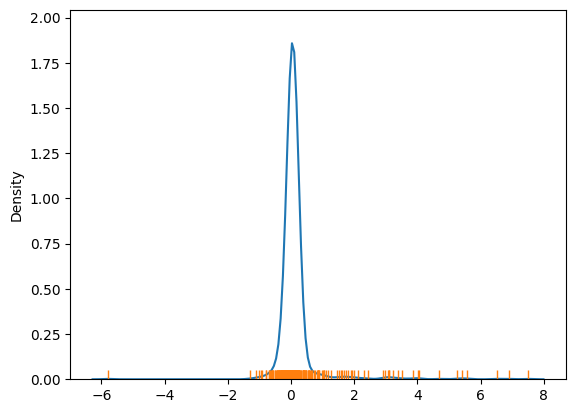

In [91]:
#Perform Local Moran's I Analaysis 
lisa = esda.moran.Moran_Local(gdf_ct['count_norm'], w)
# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

### Create moran scatterplot

Setup of the y-axis represents the spatially lagged values of the normalized eviction counts. The scatter plot helps identify spatial patterns in the distribution of eviction counts. Clusters in the scatter plot may suggest areas with similar eviction counts. Positive spatial autocorrelation indicates spatial clustering of similar values. Negative spatial autocorrelation suggests dispersion of high and low values.The LA data is heavily concentrated around the negative 0.5 and 2.5 and some few outlier values after 5.0 value.

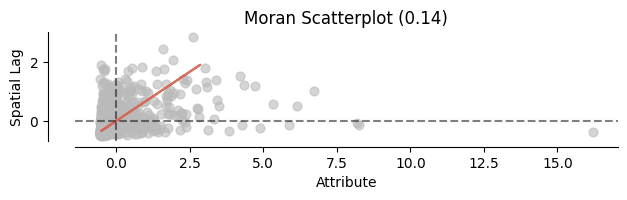

In [92]:
# Set y to list of normalized eviction count
y = gdf_ct['count_norm']

# Initialize moran plot and then graph
moran = Moran(y,w)
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

### Plot Reference Distribution

The step below is examining Moran's I Simulation Plot to understand the statistical significance of spatial autocorrelation. Utilize a simulation approach to test the null hypothesis of spatial randomness. Points on the plot represent the Moran's I values from each iteration in the simulation. The observed Moran's I is compared with the distribution of simulated values. The statistical significance is determined by assessing where the observed Moran's I falls in the distribution. A Moran's I value of 0.13 suggests a positive spatial autocorrelation in the dataset. The Moran's I statistic ranges from -1 to 1, where positive values indicate clustering (similar values near each other) and negative values indicate dispersion (dissimilar values near each other). In this case, the positive value suggests that census tracts with high eviction rates are spatially clustered, meaning neighboring tracts tend to have similar eviction rates. The magnitude (0.13) indicates a moderate degree of positive spatial autocorrelation, implying that there is a spatial pattern in the distribution of eviction rates across LA county

/Users/jackfukushima/anaconda3/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.14', ylabel='Density'>)

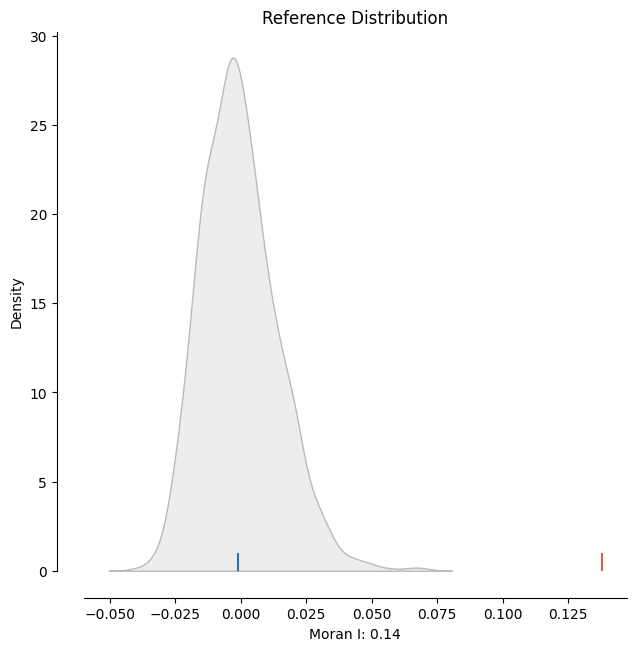

In [93]:
#Plot Moran's I Simulation Plot 
plot_moran_simulation(moran,aspect_equal=False)

### Visualize weighted count vs original, normalized count

The step below show two subplots created to visualize spatial patterns in evictions. The first subplot (ax1) displays a choropleth map of the spatial lag of evictions per 1000 renter-occupied units, while the second subplot (ax2) displays a choropleth map of evictions per 1000 renter-occupied units without considering spatial lag. The maps provide insights into the spatial distribution of evictions, with and without considering spatial lag, allowing for a comparison of patterns across different geographic units.

Spatial Lag of Evictions (ax1) map - Darker shades indicate areas with a higher spatial lag of evictions per 1000 renter-occupied units.
Clusters of darker regions suggest spatial dependencies, indicating that areas with high eviction rates are spatially correlated with neighboring areas with high eviction rates.

Evictions per 1000 Renter-Occupied Units (ax2)- The second plot represents the raw count of evictions per 1000 renter-occupied units without considering spatial lag. Darker regions indicate higher eviction rates, allowing for a comparison of localized patterns with the first plot.

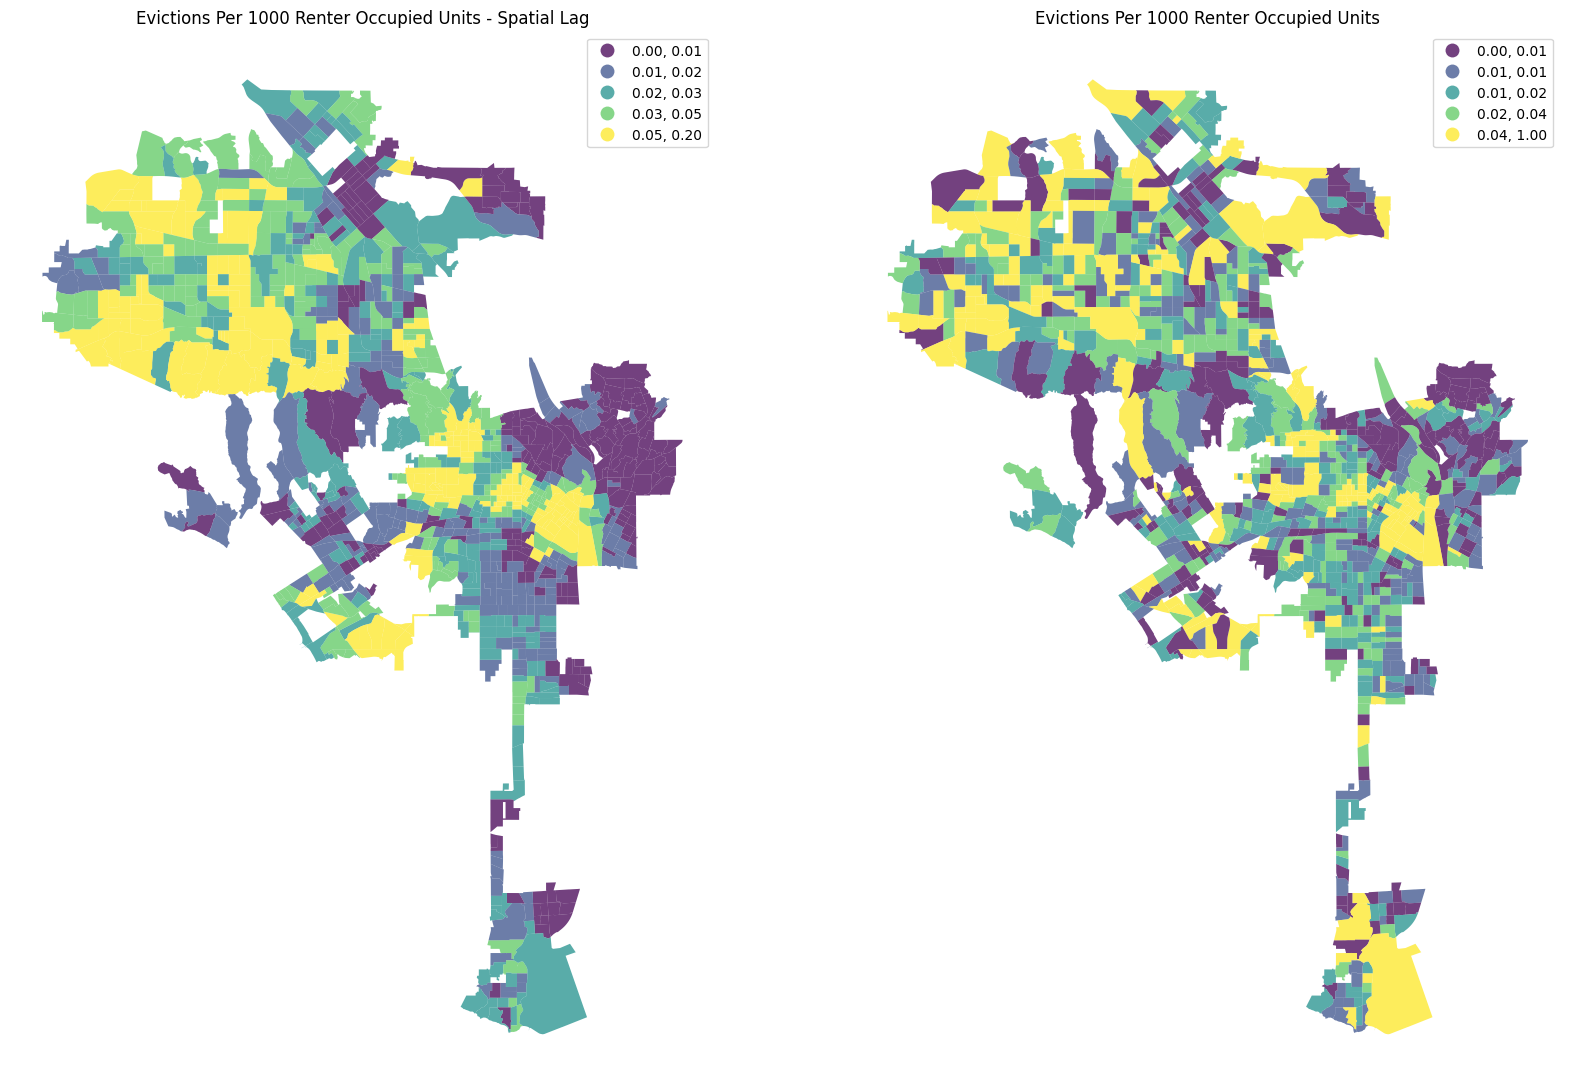

In [94]:
# Plot Choropleth Maps for Evictions per 1000 renter occupied units with and without spatial lag
f, axs = plt.subplots(1,2,figsize=(20, 16))
ax1, ax2 = axs

gdf_ct.plot(
    column="w_count",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)

gdf_ct.plot(
    column="count_norm",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)

ax1.axis('off')
ax2.axis('off')
ax1.set_title('Evictions Per 1000 Renter Occupied Units - Spatial Lag')
ax2.set_title('Evictions Per 1000 Renter Occupied Units')
plt.show()

### Calculate local moran values, plot values, and visualize clusters

The code below calculates local Moran values for each observation in the dataset based on the variable 'y' using a spatial weights matrix 'w'

In [95]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, w)

The step below generates a Moran scatterplot to visualize the local spatial autocorrelation of evictions. The plot includes points representing each observation, and their position indicates the relationship between the observed evictions and the spatial lag of evictions (a weighted average of neighboring values). The labels HH, HL, LH, and LL categorize each observation based on its spatial autocorrelation pattern.

HH (High-High): Indicates clusters of census tracts with high eviction rates surrounded by neighboring tracts with high eviction rates. This suggests spatial clustering of high eviction areas. HL (High-Low): Represents census tracts with high eviction rates surrounded by tracts with low eviction rates. This pattern suggests outliers or spatial outliers where high eviction areas are surrounded by low eviction areas. LH (Low-High): Depicts census tracts with low eviction rates surrounded by tracts with high eviction rates. This pattern implies the presence of areas with lower eviction rates surrounded by high eviction areas. LL (Low-Low): Shows clusters of census tracts with low eviction rates surrounded by neighboring tracts with low eviction rates. This indicates spatial clustering of low eviction areas.

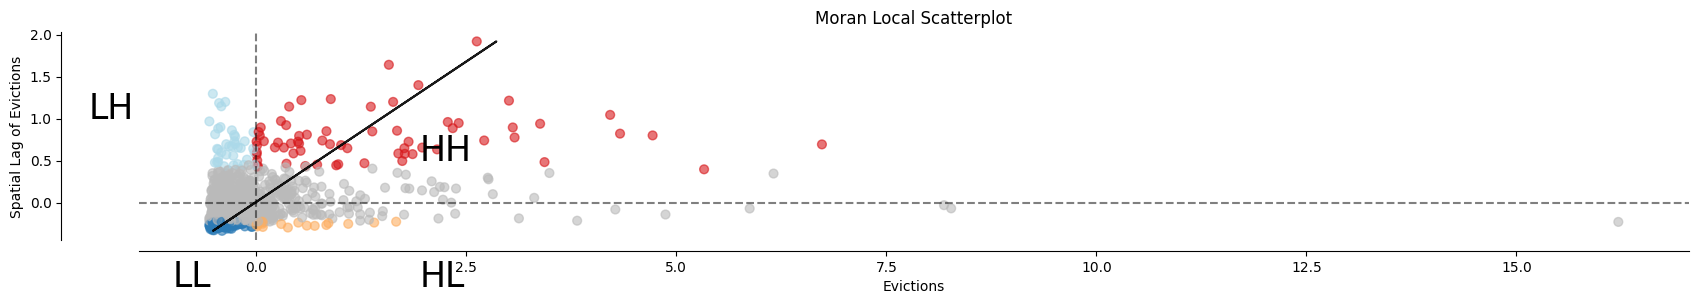

In [96]:
# Plot
fig,ax = plt.subplots(figsize=(20,20))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Evictions")
ax.set_ylabel('Spatial Lag of Evictions')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

The code below generates a spatial cluster map based on the Local Moran's I analysis. It visualizes significant spatial clusters of evictions in the census tracts, helping to identify areas with similar eviction patterns and indicating whether there are clusters of high or low evictions. HH are high hot spots.

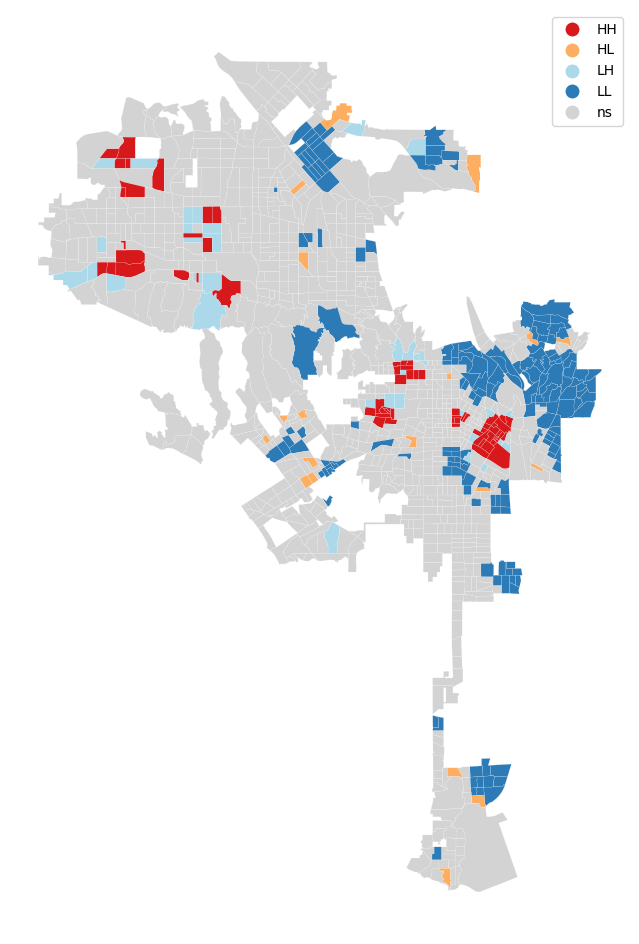

In [97]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf_ct, p=0.05, ax=ax)
plt.show()

This step does a side-by-side comparison of two Local Moran's I cluster maps, one with a significance threshold (p-value) of 0.05 and the other with a more stringent threshold of 0.01. The maps highlight spatial clusters of evictions, providing insights into the significance of these clusters.

The left map, with a significance threshold (p-value) of 0.05, indicates areas with statistically significant high-high (HH) and low-low (LL) clusters. High-high clusters suggest spatially concentrated areas with high evictions surrounded by other high-eviction areas, while low-low clusters indicate spatially concentrated areas with low evictions surrounded by other low-eviction areas.

The right map, with a more stringent p-value of 0.01, highlights only the most statistically significant clusters. This map helps identify areas with stronger evidence of local spatial autocorrelation in evictions

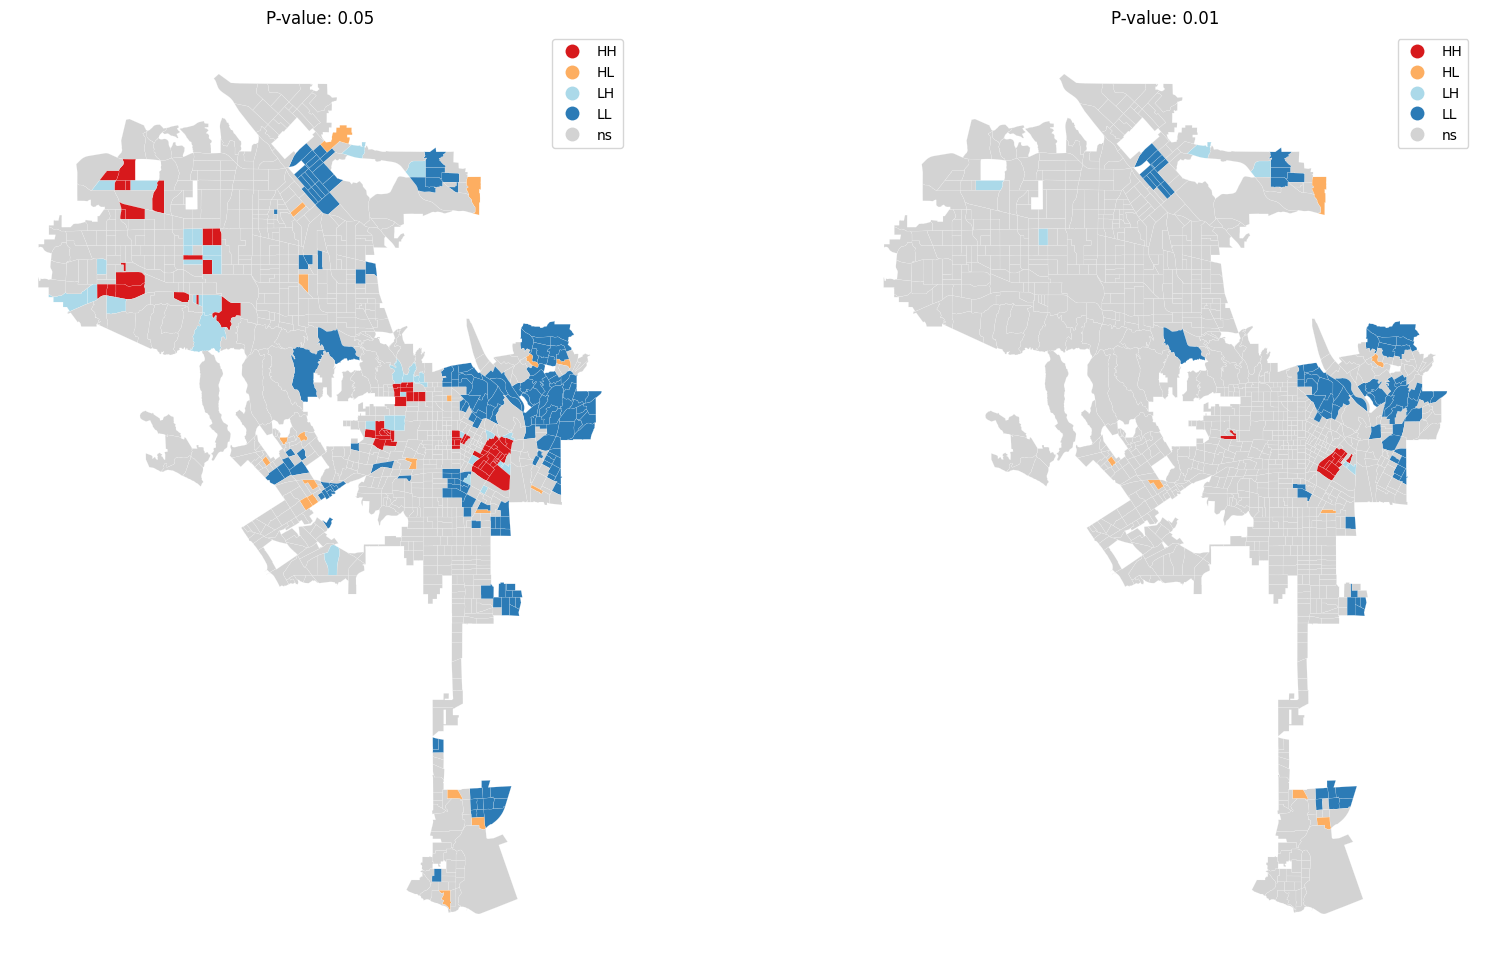

In [98]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa, gdf_ct, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, gdf_ct, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

The code below creates a binary variable, 'evic_risk,' which classifies tracts as 'high' or 'low' eviction rate based on whether their normalized eviction count is above or below the mean. The resulting map visualizes these categories, with 'high' eviction rate tracts in one color and 'low' eviction rate tracts in another, providing a spatial representation of areas with different eviction risk levels.
This binary classification allows for a clear visualization of areas that are at a higher than mean risk of evictions(True) and those with lower than or equal to the mean eviction risks (False).

/var/folders/6m/h91b_7rn0556n1htz41z92g00000gn/T/ipykernel_22244/586694209.py:8: FutureWarning:

'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)



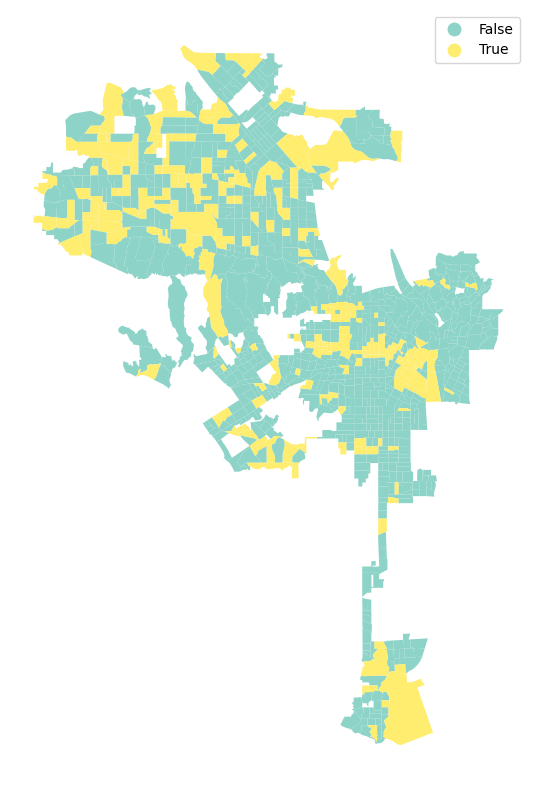

In [99]:
# Create a binary variable to subset 'high' eviction rate tracts and 'low' eviction rate tracts
evic_mean = gdf_ct['count_norm'].mean()
gdf_ct['evic_risk'] = gdf_ct['count_norm']>evic_mean

# Visualize the new variable
f, ax = plt.subplots(1,figsize=(10,10))

gdf_ct.plot(
    ax=ax,
    column='evic_risk',
    categorical=True,
    legend=True,
    colormap='Set3',
)
ax.set_axis_off()
plt.show()

The code below transforms the spatial weights matrix (w) to be row-standardized ("O") and then conducts a Join Count analysis to examine spatial autocorrelation among binary variables. In this case, the binary variable is 'evic_risk', which categorizes tracts into high or low eviction risk. The results show both observed and expected counts, along with their corresponding p-values, offering insights into the spatial patterns of low and high eviction risk tracts and whether the observed patterns are statistically significant. The results show The "Predicted" section providing expected counts under the assumption of spatial randomness. The "p-values" section indicates the statistical significance of the observed counts compared to the expected counts.The analysis reveals significant spatial clustering of tracts with low eviction risk, while the spatial relationships between tracts with different eviction risk levels do not show statistical significance.
Low-Low (bb): Number of pairs of neighboring tracts with low eviction risk.
Low-High (bw): Number of pairs of neighboring tracts with one low and one high eviction risk.
High-High (ww): Number of pairs of neighboring tracts with high eviction risk

In [100]:
# Transform
w.transform = "O"
jc = esda.join_counts.Join_Counts(gdf_ct['evic_risk'], w)
jc_table = pd.DataFrame(data=[
    [jc.bb,jc.bw,jc.ww,(jc.bb+jc.bw+jc.ww)],
    [jc.mean_bb,jc.mean_bw,'na','na'],
    [jc.p_sim_bb,jc.p_sim_bw,'na','na']],
    columns= ['Low-Low','Low-High','High-High','Sum'],index=['Actual', 'Predicted', 'p-values'])
jc_table

,Low-Low,Low-High,High-High,Sum
Actual,456.00000,1298.000000,2586.0,4340.0
Predicted,280.35035,1647.562563,na,na
p-values,0.00100,1.000000,na,na


The code gdf_ct = gdf_ct.dropna() removes rows with missing values from the GeoDataFrame gdf_ct

In [101]:
#drop null values 
gdf_ct = gdf_ct.dropna()

The code below gdf_ct.shape returns the dimensions of the GeoDataFrame gdf_ct, providing the number of rows and columns in the dataset. The output will be in the format (number of rows, number of columns).

In [102]:
gdf_ct.shape

(1085, 24)

The code below defines a function fml that takes two parameters: dep_vars (a list of dependent variables) and ind_vars (a string of independent variables). Inside the function, it constructs a formula string for a regression model using the provided dependent and independent variables. The formula is created in the format suitable for regression models in Python, with the dependent variables on the left side of the tilde (~) and the independent variables on the right side, separated by plus signs (+). The constructed formula string is then returned.

In [103]:
dep_variables = [
    'pov_below150',
    'unemployed',
    'no_high_school',
    'minority_pop',
    'mobile_homes',
    'crowded_units',
    'renter_occupied'
 ]

def fml(dep_vars,ind_vars):
    var_str = ind_vars + " ~ " + " + ".join(dep_vars)
    return var_str


The code below constructs a negative binomial regression model using the Generalized Linear Models (GLM) framework from the statsmodels library. It defines a formula string, converts data and formula into matrices, augments the independent variables matrix with a constant term, specifies and fits a negative binomial GLM, and prints the summary of the regression results, including coefficients and statistical significance of the specified independent variables in predicting the dependent variable 'count_norm'.

In [104]:
vars = fml(dep_variables,'count_norm')

y, X = dmatrices(vars,gdf_ct,return_type='dataframe')

X = add_constant(X)
model = sm.GLM(y,X,family=sm.families.Gaussian())
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             count_norm   No. Observations:                 1085
Model:                            GLM   Df Residuals:                     1077
Model Family:                Gaussian   Df Model:                            7
Link Function:               Identity   Scale:                       0.0033775
Method:                          IRLS   Log-Likelihood:                 1551.6
Date:                Tue, 19 Mar 2024   Deviance:                       3.6376
Time:                        13:53:59   Pearson chi2:                     3.64
No. Iterations:                     3   Pseudo R-squ. (CS):            0.05806
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0336      0.006     